In [20]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

date_format="%m/%d/%Y %H:%M"
date_parse = lambda date: dt.datetime.strptime(date, date_format)
# dat = pd.read_csv("/home/ciaran/knn_Q_1-12.csv")
# dat = pd.read_csv("/home/ciaran/lasso_Q_1-12.csv")
dat = pd.read_csv("/home/ciaran/lgbm_Q_T.csv")
# dat = pd.read_csv("/home/ciaran/rf_Q_1-12.csv")
# dat = pd.read_csv("/home/ciaran/SH_Q_1-12.csv")
# dat = pd.read_csv("/home/ciaran/MH_Q_1-12.csv")

dat1=pd.DataFrame(dat)

(17520, 1)

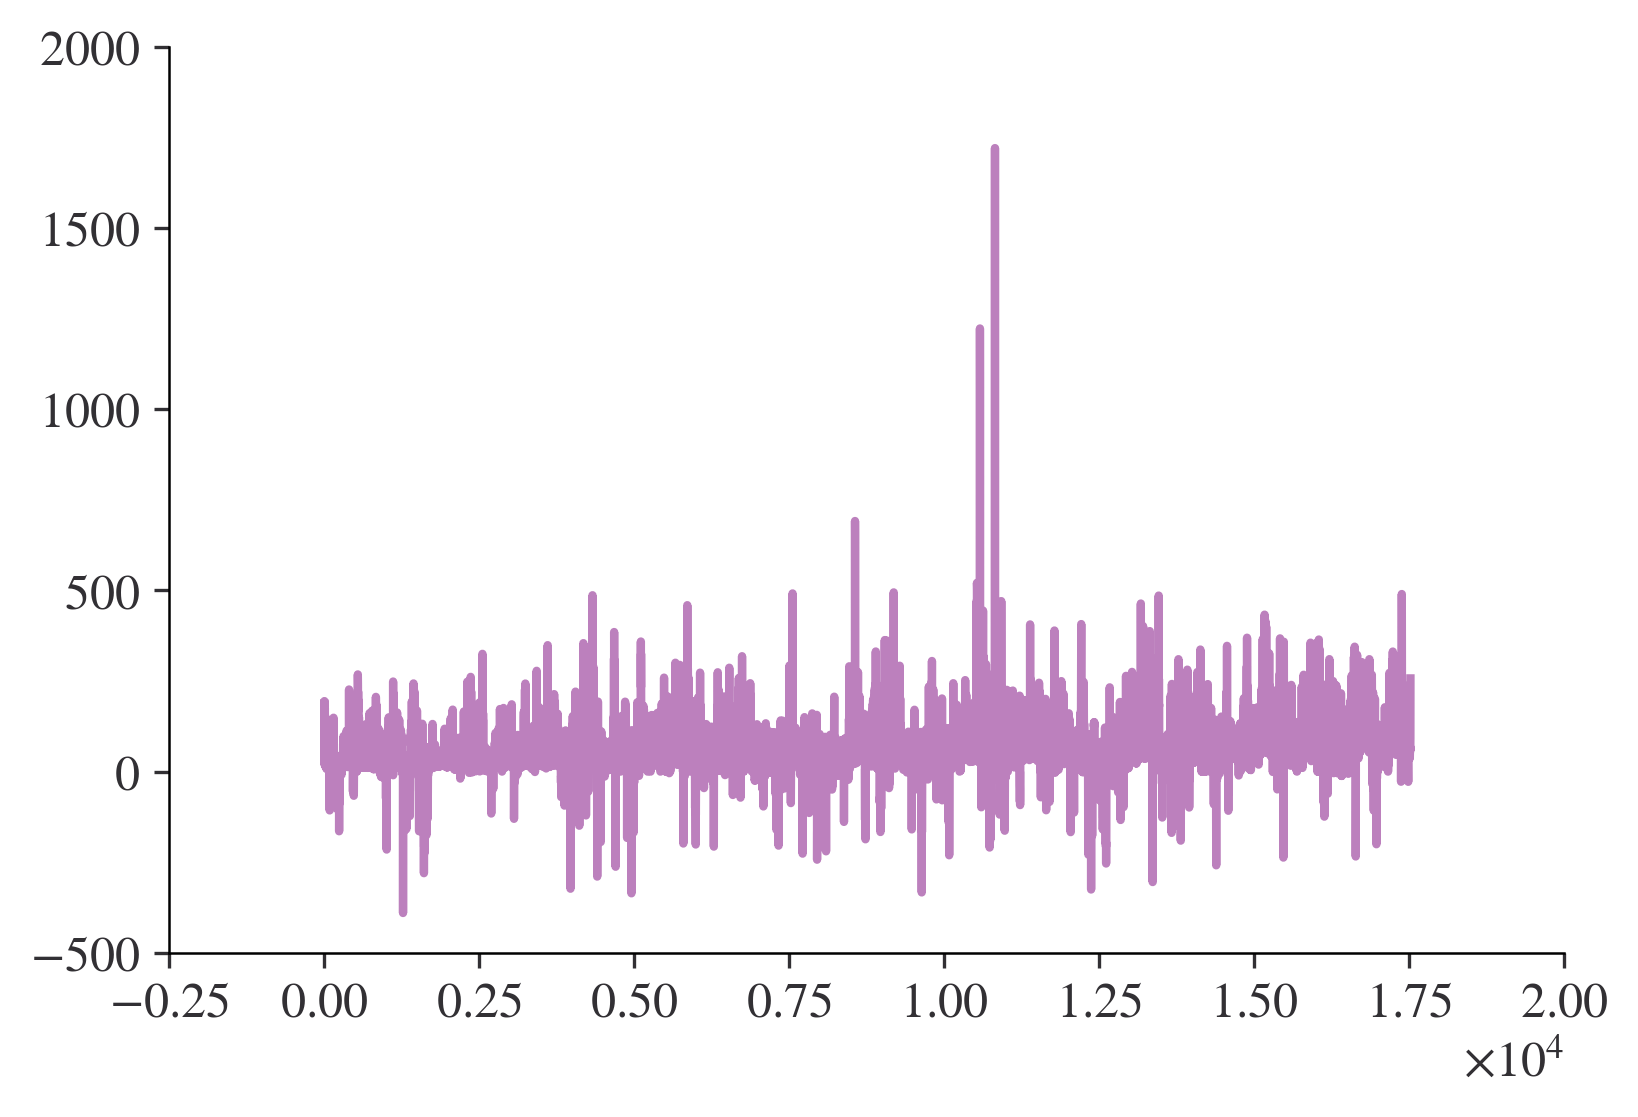

In [21]:
column_names = ['lag_{}y_Forecast_10'.format(i) for i in range(2, 18)]
Q_10=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y_Forecast_30'.format(i) for i in range(2, 18)]
Q_30=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y_Forecast_50'.format(i) for i in range(2, 18)]
Q_50=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y_Forecast_70'.format(i) for i in range(2, 18)]
Q_70=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y_Forecast_90'.format(i) for i in range(2, 18)]
Q_90=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y'.format(i) for i in range(2, 18)]
Y_r=dat1[column_names].dropna().stack().reset_index()

plt.plot(Y_r.iloc[:, 2:])
Y_r.iloc[:, 2:].shape

working attempt where we can restrict the appraoch to purchase when the 70th quantile prediction at time point i is less than the 30th quantile prediction at a later time point i+j.

No optimisation used here, this is just representative of a working example. Optimisation approach included further down.

In [22]:
def calculate_profits(quantile_70_predictions, quantile_30_predictions, real_prices):
    funds = 1000
    profits = 0
    trade_log = []
    max_units = 1


    num_trades = 0
    last_sell_timestamp = 0

    for i in range(len(quantile_70_predictions)):
        if i < last_sell_timestamp:
            continue

        for j in range(1, len(quantile_70_predictions)-i):
            
            if quantile_70_predictions[i] < quantile_30_predictions[i+j]:
                
                purchase_price = real_prices[i]
                sell_price = real_prices[i+j]
                
                units = min(max_units, funds // purchase_price)
                profit = units * (sell_price - purchase_price)
                
                profits += profit
                funds = (sell_price/purchase_price) * funds
                
                trade_log.append((i, i+j, purchase_price, sell_price, units, profit))
                
                num_trades += 1
                last_sell_timestamp = i+j
                
                break

    return profits, trade_log, num_trades, units, funds

quantile_30_predictions = np.array(pd.DataFrame(Q_10.iloc[:, 2:]))
quantile_70_predictions = np.array(pd.DataFrame(Q_90.iloc[:, 2:]))
real_prices = np.array(pd.DataFrame(Y_r.iloc[:, 2:]))

total_profits, trade_log, num_trades, units, funds = calculate_profits(quantile_70_predictions, quantile_30_predictions, real_prices)
print(total_profits)
print(num_trades)
print(units)
print(funds)

trade_log




[377.55]
2
1
[13770.23549504]


[(3, 15184, array([40.34]), array([366.19]), 1, array([325.85])),
 (15343, 17248, array([100.01]), array([151.71]), 1, array([51.7]))]

Of interest, increasing the funds also changes the multiple of profits, likely as funds is not constrained by unit
size or quantity like profits are, ignoring our effect on the price.

what I'll do is collect predictions for the DAM over the same time period with the same method to see if it
makes a sunstantial difference on either trade frequence or profits levels compared to the BM

potentiall because the market is so volatile the models are learning to take a wider position on uncertainty 
forcing them to trade far less. This potentially may not be the case in the DAM allowing us to trade with greater frequency but will require a constraint that all trading periods are within each 24 hour time frame




Pasted Below is a comparison of trading off of all different quantile pairs. No constraint on maximum units, first row represents total profits, second row total trades, third row number of units purchased


In [23]:
#0.1,0.3
[2800.17]
8
[12.]
#0.1,0.5
[700.68]
5
[3.]
#0.1,0.7
[3645.99]
4
[15.]
#0.1,0.9
[1117.]
2
[9.]

#0.3,0.5
[1588.93]
9
[7.]
#0.3,0.7
[1099.07]
14
[5.]
#0.3,0.9
[6202.04]
6
[25.]

#0.5,0.7
[2516.54]
16
[11.]
#0.5,0.9
[33864.86]
11
[133.]

#0.7,0.9
[4609.31]
17
[20.]

[20.0]

Pasted Below: maximum units 1, first row total profits, second row total trades


In [24]:
#0.1,0.3
[405.58]
8
#0.1,0.5
[320.14]
5
#0.1,0.7
[304.89]
4
#0.1,0.9
[377.55]
2

#0.3,0.5
[484.33]
9
#0.3,0.7
[356.7]
14
#0.3,0.9
[429.75]
6

#0.5,0.7
[368.96]
16
#0.5,0.9
[854.84]
11

#0.7,0.9
[532.49]
17

17

Taken from google on the effects of the optimsation approach.

Using optimisation even though there will be no change in the output with the current weights of [1,1],however varying these constraints 'x0' which represents the initial value for the optimization algorithm's decision variables. In this case, the decision variables are the weights [1, 1]. The optimization algorithm will adjust these weights to maximize the profits returned by the calculate_profits() function.

The weights determine the criteria for when to buy and sell. If the weights are set to a certain value, the algorithm will be more or less likely to trade based on those criteria. For example, if w_0 is set to a very high value, the algorithm may be more likely to trade because it is taking into account the predictions of the upper quantile more heavily. This could result in a higher trading frequency.

This may be well suited to a hyper paramater search for optimal weighting for the trading portion.

In [25]:
import numpy as np
from scipy.optimize import minimize

def calculate_profits(weights, quantile_70_predictions, quantile_30_predictions, real_prices):
    funds = 1000
    profits = 0
    trade_log = []
    max_units = 1

    num_trades = 0
    last_sell_timestamp = 0

    for i in range(len(quantile_70_predictions)):
        if i < last_sell_timestamp:
            continue

        for j in range(1, len(quantile_70_predictions)-i):
            if quantile_70_predictions[i] * weights[0] < quantile_30_predictions[i+j] * weights[1]:
                purchase_price = real_prices[i]
                sell_price = real_prices[i+j]
                
                units = min(max_units, funds // purchase_price)
                profit = units * (sell_price - purchase_price)
                
                profits += profit
                funds = (sell_price/purchase_price) * funds
                
                trade_log.append((i, i+j, purchase_price, sell_price, units, profit))
                
                num_trades += 1
                last_sell_timestamp = i+j
                
                break

    return profits, trade_log, num_trades, units, funds

#lower quantile
quantile_30_predictions = np.array(pd.DataFrame(Q_10.iloc[:, 2:]))
#upper quantile
quantile_70_predictions = np.array(pd.DataFrame(Q_90.iloc[:, 2:]))
real_prices = np.array(pd.DataFrame(Y_r.iloc[:, 2:]))


def objective(weights, quantile_70_predictions, quantile_30_predictions, real_prices):
    profits, trade_log, num_trades, units, funds = calculate_profits(weights, quantile_70_predictions, quantile_30_predictions, real_prices)
    return -profits

x0 = [3, 1]

res = minimize(objective, x0, args=(quantile_70_predictions, quantile_30_predictions, real_prices), method='SLSQP')

profits, trade_log, num_trades, units, funds = calculate_profits(x0, quantile_70_predictions, quantile_30_predictions, real_prices)

# print(res.x)
print(-res.fun)
print(num_trades)
print(units)
# print(profits)
trade_log


/tmp/ipykernel_237038/4089635375.py:22: RuntimeWarning: divide by zero encountered in floor_divide
  units = min(max_units, funds // purchase_price)
/tmp/ipykernel_237038/4089635375.py:26: RuntimeWarning: divide by zero encountered in true_divide
  funds = (sell_price/purchase_price) * funds


230.79
1
1


[(225, 17232, array([0.]), array([230.79]), 1, array([230.79]))]

Plot below should highlight its a very rare occurence for the 0.9 quantile at time point i to be below the 0.1 quantile at time point i+j.

Point stands for quantile 0.7 and 0.3

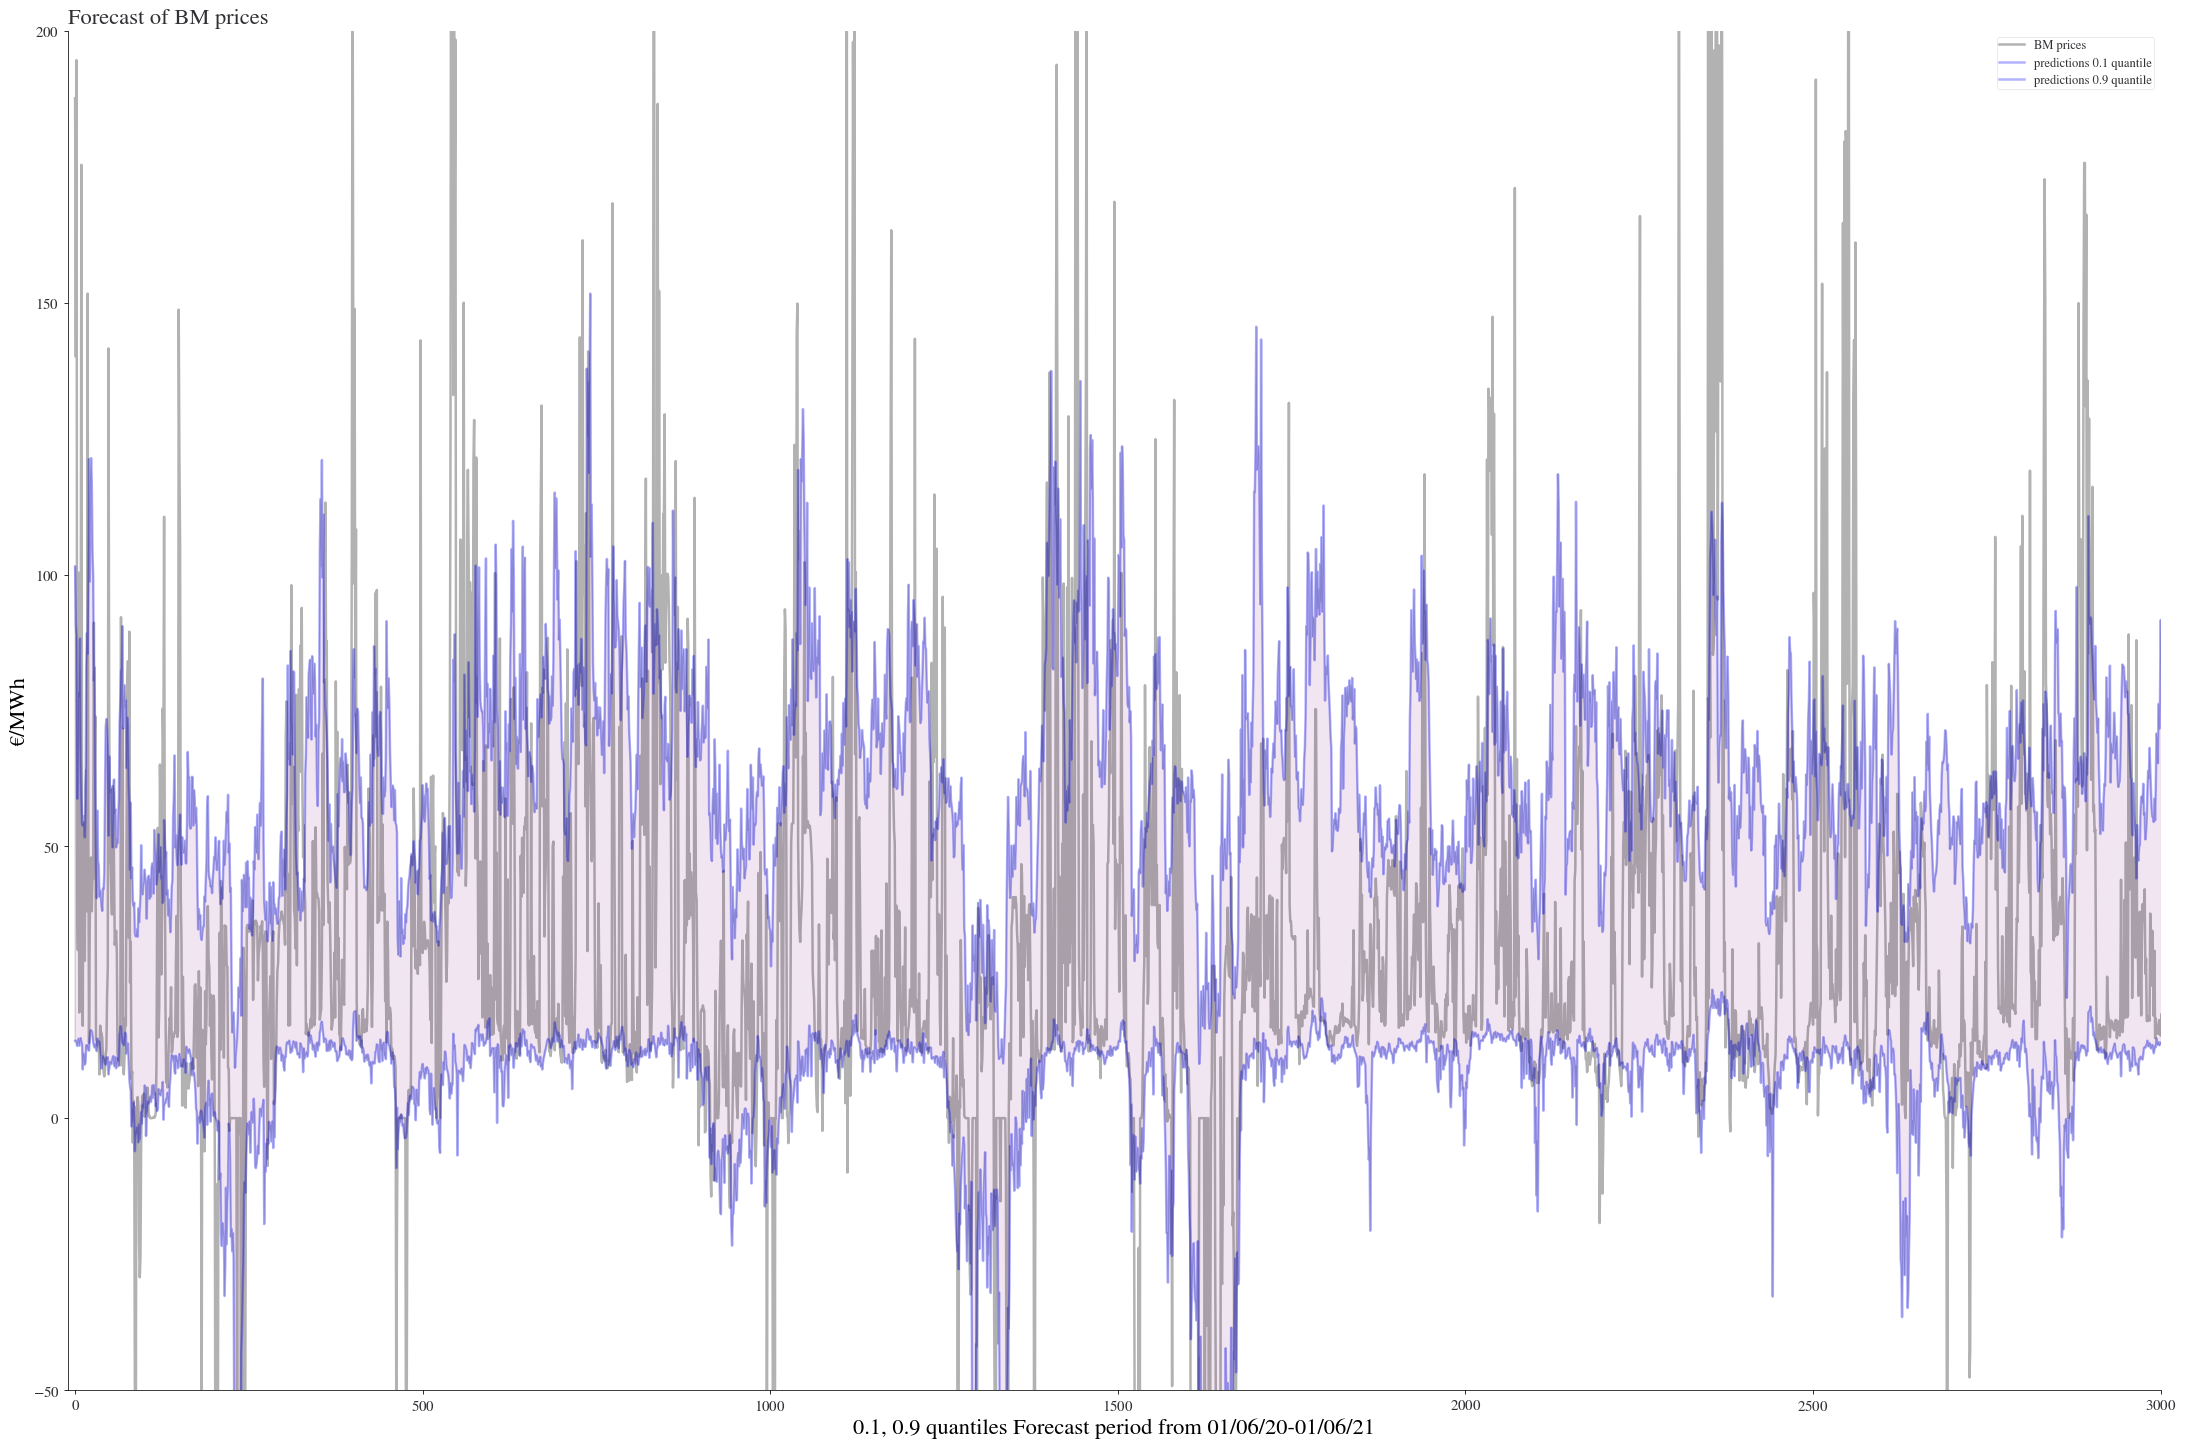

In [26]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import os
from matplotlib.ticker import ScalarFormatter,AutoMinorLocator
import matplotlib as mpl

plt.style.use('plot_style.txt')
#=========================================================== # Directory and filename; style file open #=========================================================== # Change to the directory which contains the current script 
dirFile = os.path.dirname(os.path.join('YourDirHere',
                          'NicePlotProductivity.py'))
# Load style file plt.style.use(os.path.join(dirFile, 'PaperDoubleFig.mplstyle'))
# Make some style choices for plotting 
colourWheel =['#329932',
            '#ff6961',
            'b',
            '#6a3d9a',
            '#fb9a99',
            '#e31a1c',
            '#fdbf6f',
            '#ff7f00',
            '#cab2d6',
            '#6a3d9a',
            '#ffff99',
            '#b15928',
            '#67001f',
            '#b2182b',
            '#d6604d',
            '#f4a582',
            '#fddbc7',
            '#f7f7f7',
            '#d1e5f0',
            '#92c5de',
            '#4393c3',
            '#2166ac',
            '#053061']
dashesStyles = [[3,1],
            [1000,1],
            [2,1,10,1],
            [4, 1, 1, 1, 1, 1]]





p1=Q_10.iloc[:, 2:]
p1=p1.reset_index(drop=True)
p3=Q_30.iloc[:, 2:]
p3=p3.reset_index(drop=True)
p5=Q_50.iloc[:, 2:]
p5=p5.reset_index(drop=True)
p7=Q_70.iloc[:, 2:]
p7=p7.reset_index(drop=True)
p9=Q_90.iloc[:, 2:]
p9=p9.reset_index(drop=True)
yy=Y_r.iloc[:, 2:]
yy=yy.reset_index(drop=True)

p1=p1.values.ravel()
p3=p3.values.ravel()
p5=p5.values.ravel()
p7=p7.values.ravel()
p9=p9.values.ravel()
                       
figure(figsize = (30, 20), dpi = 90)
plt.plot(yy, color='black', label='BM prices', alpha=0.3)
plt.plot(p1, color='blue', label='predictions 0.1 quantile', alpha=0.3)
# plt.plot(p3, color='yellow', label='SH DNN predictions 0.3 quantile')
# plt.plot(p5, color='red', label='SH DNN predictions 0.5 quantile')
# plt.plot(p7, color='yellow', label='SH DNN predictions 0.7 quantile')
plt.plot(p9, color='blue', label='predictions 0.9 quantile', alpha=0.3)
plt.fill_between(np.arange(0,len(yy),1), p1, p9, alpha=0.2)


plt.xlabel('0.1, 0.9 quantiles Forecast period from 01/06/20-01/06/21',fontsize=18)
plt.ylabel('€/MWh', fontsize=18)
plt.title("Forecast of BM prices", fontsize=18)
plt.xlim([-10, 3000])
plt.ylim([-50,200])
plt.legend()
# plt.savefig('SH_DNN.png', transparent=False, format="jpg")


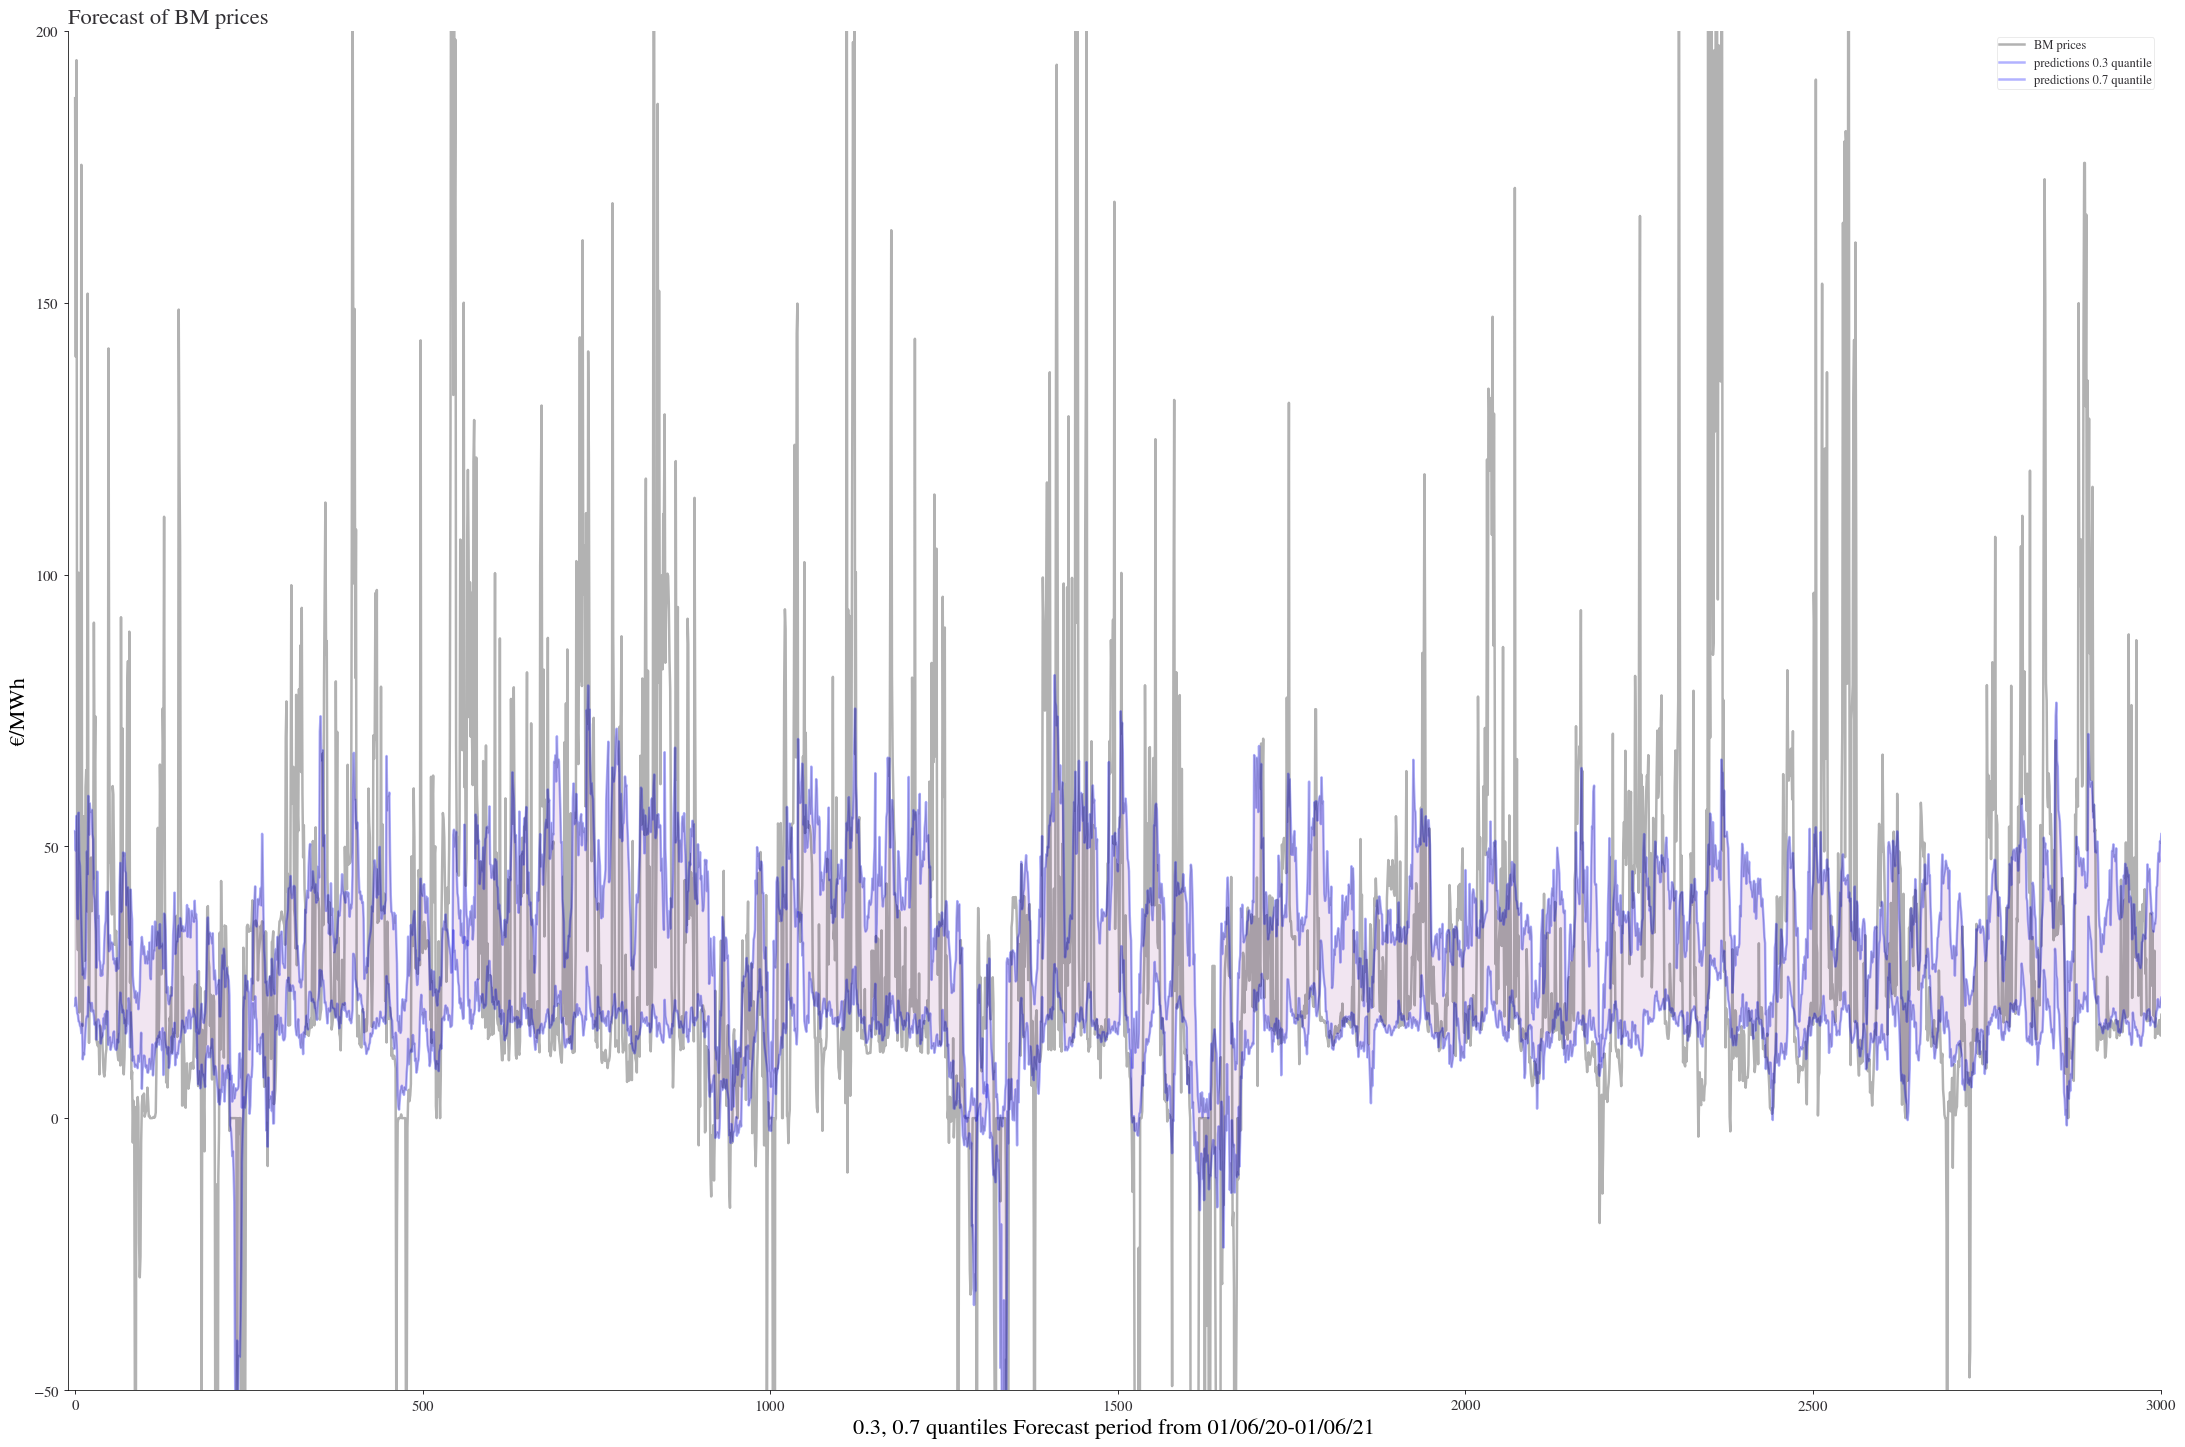

In [27]:
figure(figsize = (30, 20), dpi = 90)
plt.plot(yy, color='black', label='BM prices', alpha=0.3)
plt.plot(p3, color='blue', label='predictions 0.3 quantile', alpha=0.3)
# plt.plot(p3, color='yellow', label='SH DNN predictions 0.3 quantile')
# plt.plot(p5, color='red', label='SH DNN predictions 0.5 quantile')
# plt.plot(p7, color='yellow', label='SH DNN predictions 0.7 quantile')
plt.plot(p7, color='blue', label='predictions 0.7 quantile', alpha=0.3)
plt.fill_between(np.arange(0,len(yy),1), p3, p7, alpha=0.2)


plt.xlabel('0.3, 0.7 quantiles Forecast period from 01/06/20-01/06/21',fontsize=18)
plt.ylabel('€/MWh', fontsize=18)
plt.title("Forecast of BM prices", fontsize=18)
plt.xlim([-10, 3000])
plt.ylim([-50,200])
plt.legend()
# plt.savefig('SH_DNN.png', transparent=False, format="jpg")


Everthing below contains previous attempt at the current working code or is junk working copies adapted from articles on trading.

In [ ]:
# dat1 = df.loc[(df['lag_2y'] < -5) | (df['lag_2y'] > 5)]
# dat1 = df.loc[(df.iloc[:,:16] > 5)]
# dat1 = df.loc[(df.iloc[:,:16] > 1).all(axis=1)]
dat.shape

dat1=df

In [ ]:
def optimize_trades(quantile_70_predictions, quantile_30_predictions, real_prices, max_units):
    prob = pulp.LpProblem('Trade Optimization', pulp.LpMaximize)
    
    x = pulp.LpVariable.dicts('trade', range(len(quantile_70_predictions)), lowBound=0, upBound=1, cat='Binary')

    prob += pulp.lpSum([x[i] * (real_prices[i+j] - real_prices[i]) for i in range(len(quantile_70_predictions)) for j in range(1, len(quantile_70_predictions)-i) if quantile_70_predictions[i] < quantile_30_predictions[i+j]])
    prob += pulp.lpSum([x[i] for i in range(len(quantile_70_predictions))]) <= max_units

    status = prob.solve()
    print(pulp.LpStatus[status])
    for v in prob.variables():
        print(v.name, '=', v.varValue)
    print('Total profits =', pulp.value(prob.objective))

optimize_trades(quantile_70_predictions, quantile_30_predictions, real_prices, 10)



In [ ]:
# Declare the funds and trades variables as global variables
funds = 1000
trades = 0
trade_log = []  # Declare a list variable to store the trades

def objective_function(w, q30, q70, prices):
  profits = []

  last_trade_timestamp = -1

  max_units = 1

  global funds, trades

  for i, price in enumerate(prices[:-1]):
    for j in range(1, len(q30) - i):
      if q70[i] < q30[i + j] and i + j > last_trade_timestamp:  # Check that the sell time stamp is after the last trade timestamp
        if all(q70[i] < q70[i + j + k] for k in range(1, len(q30) - (i + j))):
          purchase_price = prices[i]
          sell_price = prices[i + j]
          
#           if sell_price <= 0:
#             continue

          units = min(max_units, funds // purchase_price)
          profit = units * (sell_price - purchase_price)
            
#           if profit <= 0:
#             continue

          profits.append(profit)
          funds += profit
          trades += 1
          trade_log.append((purchase_price, sell_price, units, profit))


          last_trade_timestamp = i + j

  total_profit = sum(profits)


  return -total_profit




df_q30 = pd.DataFrame(Q_10.iloc[:, 2:])
df_q70 = pd.DataFrame(Q_90.iloc[:, 2:])
df_prices = pd.DataFrame(Y_r.iloc[:, 2:])

# Test the objective function with the DataFrame objects
w0 = [1, 1]  # Initial values for the model parameters
res = minimize(objective_function, w0, args=(np.array(df_q30), np.array(df_q70), np.array(df_prices)))

# Print the optimized model parameters, the final value of the funds, and the number of trades
print(f'Optimized model parameters: {res.x}')
print(f'Final value of the funds: {funds}')
print(f'Number of trades: {trades}')
print(f'Number of trades: {trade_log}')

In [ ]:
trade_log

In [ ]:
# Declare the funds and trades variables as global variables
funds = 100
trades = 0
trade_log = []  # Declare a list variable to store the trades

def objective_function(q30, q70, prices):
  profits = []

  last_trade_timestamp = -1

  max_units = 1

  global funds, trades

  for i, price in enumerate(prices[:-1]):
    for j in range(1, len(q30) - i):
      if q70[i] < q30[i + j] and i + j > last_trade_timestamp:  
        if all(q70[i] < q70[i + j + k] for k in range(1, len(q30) - (i + j))):
          purchase_price = prices[i]
          sell_price = prices[i + j]
          
          units = min(max_units, funds // purchase_price)
          profit = units * (sell_price - purchase_price)
            
          profits.append(profit)
          funds += profit
          trades += 1

          trade_log.append((purchase_price, sell_price, units, profit))
          
          last_trade_timestamp = i + j

  total_profit = sum(profits)


  return -total_profit


def calculate_profits(quantile_70_predictions, quantile_30_predictions, real_prices, max_units):
    funds = 100
    profits = 0
    trade_log = []

    num_trades = 0
    last_sell_timestamp = 0

    for i in range(len(quantile_70_predictions)):
        if i < last_sell_timestamp:
            continue

        for j in range(1, len(quantile_70_predictions)-i):
            if quantile_70_predictions[i] < quantile_30_predictions[i+j]:
                purchase_price = real_prices[i]
                sell_price = real_prices[i+j]
                units = min(max_units, funds // purchase_price)
                profit = units * (sell_price - purchase_price)
                profits += profit
                funds = (sell_price/purchase_price) * funds
                trade_log.append((i, j, purchase_price, sell_price, units, profit))
                num_trades += 1
                last_sell_timestamp = i+j
                break

    return profits




# df_q30 = pd.DataFrame(Q_10.iloc[:, 2:])
# df_q70 = pd.DataFrame(Q_90.iloc[:, 2:])
# df_prices = pd.DataFrame(Y_r.iloc[:, 2:])

df_q30 =    [100, 110, 120, 130, 140, 150, 160]
df_q70 =    [90,  100, 150, 120, 190, 140, 190]
df_prices = [100,  60, 120, 30, 140, 150, 60]

objective_function(np.array(df_q30), np.array(df_q70), np.array(df_prices))

print(f'Final value of the funds: {funds}')
print(f'Number of trades: {trades}')

# print(f'Trade log: {trade_log}')


In [ ]:
trade_log
#purchase_price, sell_price, units, profit

In [ ]:
trade_log

In [ ]:
def calculate_profits(quantile_70_predictions, quantile_30_predictions, real_prices):
    funds = 100
    profits = 0
    trade_log = []

    num_trades = 0
    last_sell_timestamp = 0

    for i in range(len(quantile_70_predictions)):
        if i < last_sell_timestamp:
            continue

        for j in range(1, len(quantile_70_predictions)-i):
            if quantile_70_predictions[i] < quantile_30_predictions[i+j]:
                purchase_price = real_prices[i]
                sell_price = real_prices[i+j]
                profits += sell_price - purchase_price
                funds = (sell_price/purchase_price) * funds
                trade_log.append((i, j, purchase_price, sell_price))
                num_trades += 1
                last_sell_timestamp = i+j
                break

    return profits, trade_log, num_trades


quantile_70_predictions = np.array(pd.DataFrame(Q_90.iloc[:, 2:]))
quantile_30_predictions = np.array(pd.DataFrame(Q_10.iloc[:, 2:]))
real_prices = np.array(pd.DataFrame(Y_r.iloc[:, 2:]))

total_profits, trade_log, num_trades = calculate_profits(quantile_70_predictions, quantile_30_predictions, real_prices)
print(total_profits)
print(trade_log)
print(num_trades)


In [ ]:
trade_log

In [ ]:
def calculate_profits(quantile_70_predictions, quantile_30_predictions, real_prices):
    funds = 100
    profits = 0
    trade_log = []
    max_units = 1


    num_trades = 0
    last_sell_timestamp = 0

    for i in range(len(quantile_70_predictions)):
        if i < last_sell_timestamp:
            continue

        for j in range(1, len(quantile_70_predictions)-i):
            if quantile_70_predictions[i] < quantile_30_predictions[i+j]:
                purchase_price = real_prices[i]
                sell_price = real_prices[i+j]
                units = min(max_units, funds // purchase_price)
                profit = units * (sell_price - purchase_price)
                profits += profit
                funds = (sell_price/purchase_price) * funds
                trade_log.append((i, j, purchase_price, sell_price, units, profit))
                num_trades += 1
                last_sell_timestamp = i+j
                break

    return profits, trade_log, num_trades

quantile_70_predictions = np.array(pd.DataFrame(Q_90.iloc[:, 2:]))
quantile_30_predictions = np.array(pd.DataFrame(Q_10.iloc[:, 2:]))
real_prices = np.array(pd.DataFrame(Y_r.iloc[:, 2:]))

total_profits, trade_log, num_trades = calculate_profits(quantile_70_predictions, quantile_30_predictions, real_prices)
print(total_profits)
# print(trade_log)
print(num_trades)
trade_log

In [ ]:
trade_log

In [ ]:
funds = 1000
trades = 0

def objective_function(w, q30, q70, prices):
  profits = []

  last_trade_timestamp = -1

  trade_threshold = 0.5

  for i, price in enumerate(prices[:-1]):
    for j in range(1, len(q30) - i):
      if q70[i] < q30[i + j] and i + j > last_trade_timestamp:  
        if all(q70[i] < q70[i + j + k] for k in range(1, len(q30) - (i + j))):
          purchase_price = prices[i]
          sell_price = prices[i + j]

          if sell_price > (1 + trade_threshold) * purchase_price:
            continue  

          profit = sell_price - purchase_price

          profits.append(profit)
          global funds, trades  
          funds = funds + (sell_price - purchase_price)
          trades += 1 
        
          last_trade_timestamp = i + j

  total_profit = sum(profits)


  return -total_profit

df_q30 = pd.DataFrame(Q_30.iloc[:, 2:])
df_q70 = pd.DataFrame(Q_70.iloc[:, 2:])
df_prices = pd.DataFrame(Y_r.iloc[:, 2:])

w0 = [1, 1]  
res = minimize(objective_function, w0, args=(np.array(df_q30), np.array(df_q70), np.array(df_prices)))

print(f'Optimized model parameters: {res.x}')
print(f'Final value of the funds: {funds}')
print(f'Number of trades: {trades}')

In [ ]:

funds = 1000
trades = 0

def objective_function(w, q30, q70, prices):
  profits = []

  last_trade_timestamp = -1

  for i, price in enumerate(prices[:-1]):
    for j in range(1, len(q30) - i):
      if q70[i] < q30[i + j] and i + j > last_trade_timestamp:  
        if all(q70[i] < q70[i + j + k] for k in range(1, len(q30) - (i + j))):
          purchase_price = prices[i]
          sell_price = prices[i + j]

          profit = sell_price - purchase_price

          profits.append(profit)
          global funds, trades  
          funds = (sell_price / purchase_price) * funds
          trades += 1  
        
          last_trade_timestamp = i + j

  total_profit = sum(profits)


  return -total_profit



df_q30 = pd.DataFrame(Q_10.iloc[:, 2:])
df_q70 = pd.DataFrame(Q_90.iloc[:, 2:])
df_prices = pd.DataFrame(Y_r.iloc[:, 2:])

w0 = [1, 1]  
res = minimize(objective_function, w0, args=(np.array(df_q30), np.array(df_q70), np.array(df_prices)))

print(f'Optimized model parameters: {res.x}')
print(f'Final value of the funds: {funds}')
print(f'Number of trades: {trades}')

In [ ]:
p1=Q_10.iloc[:, 2:].values.ravel()
yy= Y_r.iloc[:, 2:].values.ravel()
p9=Q_90.iloc[:, 2:].values.ravel()
                       
figure(figsize = (30, 20), dpi = 90)
plt.plot(yy, color='black', label='BM prices', alpha=0.6)
plt.plot(p1, color='blue', label='SH DNN predictions 0.1 quantile', alpha=0.2)
# plt.plot(p3, color='yellow', label='SH DNN predictions 0.3 quantile')
# plt.plot(p5, color='red', label='SH DNN predictions 0.5 quantile')
# plt.plot(p7, color='yellow', label='SH DNN predictions 0.7 quantile')
plt.plot(p9, color='blue', label='SH DNN predictions 0.9 quantile', alpha=0.2)
plt.fill_between(np.arange(0,len(yy),1), p1, p9, alpha=0.4)
